# ML4MSD - Homework 4: Assignment 2
# Materials Project API + DScribe Featurization Pipeline

**Author**: Ardavan Mehdizadeh  
**Date**: Oct 20, 2025  

## Objective

Query Materials Project API to get 1-3k materials, then run a complete ML pipeline using DScribe structural featurizers.

## Query Strategy

I'll query for materials with:
- Band gap between 0.5 and 3.0 eV (semiconductors)
- Energy above hull < 0.05 eV/atom (stable materials)
- 2-4 elements (simple compounds)
- Has structure data

**Target property**: Band gap (It relates to electronic properties of layered materials)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.io.ase import AseAtomsAdaptor
from dscribe.descriptors import SOAP
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Import API key
try:
    from config import MP_API_KEY
    print("✓ API key loaded from config.py")
except ImportError:
    print("❌ Error: config.py not found!")
    print("Please create config.py with your MP_API_KEY")
    raise

/Users/mehdizadeh.a/Library/CloudStorage/OneDrive-NortheasternUniversity/ML4MSD-HW-Ardavan/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ API key loaded from config.py


In [2]:
# Query Materials Project - VERY SELECTIVE for 1-2k materials
print("="*60)
print("QUERYING MATERIALS PROJECT")
print("="*60)

with MPRester(MP_API_KEY) as mpr:
    # Very selective query
    docs = mpr.materials.summary.search(
        band_gap=(1.5, 2.5),           # Narrow
        energy_above_hull=(0, 0.01),   # Very stable only
        num_elements=(2, 3),            # Binary and ternary
        num_sites=(1, 30),              # Small cells only
        is_stable=True,                 # Only stable phases
        fields=[
            "material_id",
            "formula_pretty", 
            "band_gap",
            "energy_above_hull",
            "structure",
            "nsites",
            "nelements"
        ]
    )

print(f"✓ Retrieved {len(docs)} materials")

# Ensure we have a manageable size
if len(docs) > 2000:
    import random
    random.seed(17)
    docs = random.sample(docs, 2000)
    print(f"✓ Sampled to {len(docs)} materials for computational efficiency")
elif len(docs) < 500:
    print("⚠️ Warning: Dataset may be too small, consider relaxing constraints")

# Convert to DataFrame
data = []
for doc in docs:
    data.append({
        'material_id': doc.material_id,
        'formula': doc.formula_pretty,
        'band_gap': doc.band_gap,
        'energy_above_hull': doc.energy_above_hull,
        'structure': doc.structure,
        'nsites': doc.nsites,
        'nelements': doc.nelements
    })

df = pd.DataFrame(data)
print(f"\n✅ Final dataset: {len(df)} materials")
print(f"Band gap range: {df['band_gap'].min():.2f} - {df['band_gap'].max():.2f} eV")
print(f"Sites per cell: {df['nsites'].min()}-{df['nsites'].max()}")

QUERYING MATERIALS PROJECT


Retrieving SummaryDoc documents: 100%|██████████| 1386/1386 [00:01<00:00, 894.87it/s]

✓ Retrieved 1386 materials

✅ Final dataset: 1386 materials
Band gap range: 1.50 - 2.50 eV
Sites per cell: 2-30


In [3]:
# Explore the dataset
print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)
print(df.describe())

print("\nTarget variable (band_gap) distribution:")
print(df['band_gap'].describe())

# Check for any None/NaN values
print(f"\nMissing values:")
print(df.isnull().sum())

# Remove any entries with missing structures or band gaps
df = df.dropna(subset=['structure', 'band_gap'])
print(f"\nFinal dataset size after cleaning: {len(df)} materials")


DATASET STATISTICS
          band_gap  energy_above_hull       nsites    nelements
count  1386.000000             1386.0  1386.000000  1386.000000
mean      1.990598                0.0    15.145022     2.876623
std       0.278754                0.0     8.248568     0.328988
min       1.500300                0.0     2.000000     2.000000
25%       1.756775                0.0     8.000000     3.000000
50%       1.989250                0.0    14.000000     3.000000
75%       2.225175                0.0    22.000000     3.000000
max       2.497000                0.0    30.000000     3.000000

Target variable (band_gap) distribution:
count    1386.000000
mean        1.990598
std         0.278754
min         1.500300
25%         1.756775
50%         1.989250
75%         2.225175
max         2.497000
Name: band_gap, dtype: float64

Missing values:
material_id          0
formula              0
band_gap             0
energy_above_hull    0
structure            0
nsites               0
nelement

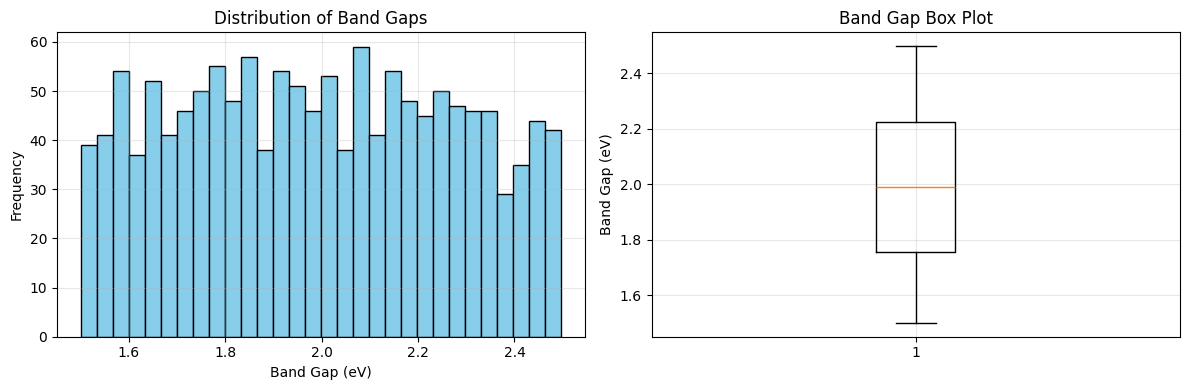

✓ Target distribution visualized


In [4]:
# Visualize band gap distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['band_gap'], bins=30, edgecolor='black', color='skyblue')
axes[0].set_xlabel('Band Gap (eV)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Band Gaps')
axes[0].grid(alpha=0.3)

axes[1].boxplot(df['band_gap'])
axes[1].set_ylabel('Band Gap (eV)')
axes[1].set_title('Band Gap Box Plot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('mp_bandgap_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Target distribution visualized")

## Structural Featurization with DScribe SOAP

SOAP (Smooth Overlap of Atomic Positions) is ideal for this task because:
- Captures local atomic environments
- Rotation and permutation invariant
- Well-suited for predicting properties dependent on local structure
- Excellent for periodic systems like crystals

In [5]:
# Get all unique species in the dataset
print("="*60)
print("SETTING UP SOAP DESCRIPTOR")
print("="*60)

species = set()
for structure in df['structure']:
    species.update([str(el) for el in structure.composition.elements])
species = sorted(list(species))

print(f"✓ Found {len(species)} unique elements")
print(f"Elements: {', '.join(species[:20])}{'...' if len(species) > 20 else ''}")

# Create SOAP descriptor
# Using smaller parameters for faster computation
soap = SOAP(
    species=species,
    periodic=True,
    r_cut=6.0,
    n_max=6,
    l_max=4,
    average="outer",  # Average over all atoms
    sparse=False
)

print(f"✓ SOAP descriptor initialized")
print(f"   r_cut: 6.0 Å")
print(f"   n_max: 6")
print(f"   l_max: 4")
print(f"   averaging: outer (global descriptor)")

SETTING UP SOAP DESCRIPTOR
✓ Found 83 unique elements
Elements: Ac, Ag, Al, As, Au, B, Ba, Be, Bi, Br, C, Ca, Cd, Ce, Cl, Co, Cr, Cs, Cu, Dy...
✓ SOAP descriptor initialized
   r_cut: 6.0 Å
   n_max: 6
   l_max: 4
   averaging: outer (global descriptor)


In [14]:
# Convert structures to ASE and featurize
print("\nFeaturizing structures with SOAP...")

ase_structures = []
valid_indices = []

for idx, structure in enumerate(df['structure']):
    try:
        ase_struct = AseAtomsAdaptor.get_atoms(structure)
        ase_structures.append(ase_struct)
        valid_indices.append(idx)
    except Exception as e:
        print(f"Warning: Could not convert structure {idx}: {e}")
        continue

print(f"✓ Converted {len(ase_structures)} structures to ASE format")

# Create SOAP features
soap_features = soap.create(ase_structures, n_jobs=-1)
print(f"✓ SOAP featurization complete: {soap_features.shape[1]} features")

# Update dataframe to only include valid structures
df = df.iloc[valid_indices].reset_index(drop=True)


Featurizing structures with SOAP...
✓ Converted 1386 structures to ASE format
✓ SOAP featurization complete: 621255 features


In [7]:
# Create feature dataframe
print("\n" + "="*60)
print("FEATURE CLEANING")
print("="*60)

X_all = pd.DataFrame(soap_features)
print(f"Initial features: {X_all.shape[1]}")

# Remove low variance features
variance_threshold = 1e-3  # Increased threshold
low_var_mask = X_all.var() > variance_threshold
X_all = X_all.loc[:, low_var_mask]
print(f"After removing low variance: {X_all.shape[1]}")

# If still too many features, use additional variance-based filtering
if X_all.shape[1] > 5000:
    print(f"Still too many features, applying stricter variance filter...")
    # Keep only top features by variance
    variances = X_all.var()
    top_features = variances.nlargest(5000).index
    X_all = X_all[top_features]
    print(f"After keeping top 5000 by variance: {X_all.shape[1]}")

# Skip correlation-based removal if too many features (too slow)
if X_all.shape[1] <= 2000:
    print("Computing correlations...")
    corr_matrix = X_all.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > 0.99)]
    X_clean = X_all.drop(columns=to_drop)
    print(f"After removing high correlation: {X_clean.shape[1]}")
else:
    print("Skipping correlation removal (too many features for efficient computation)")
    print("Using variance-filtered features directly")
    X_clean = X_all

print(f"✓ Final feature count: {X_clean.shape[1]}")


FEATURE CLEANING
Initial features: 621255
After removing low variance: 53365
Still too many features, applying stricter variance filter...
After keeping top 5000 by variance: 5000
Skipping correlation removal (too many features for efficient computation)
Using variance-filtered features directly
✓ Final feature count: 5000


In [8]:
# Prepare target and features
y = df['band_gap'].values
X = X_clean.values

print(f"\nFinal dataset shape:")
print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")

# Check for any NaN or inf values
if np.any(np.isnan(X)) or np.any(np.isinf(X)):
    print("Warning: Found NaN or inf values, replacing with 0")
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

if np.any(np.isnan(y)) or np.any(np.isinf(y)):
    print("Warning: Found NaN or inf in target")
    y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)


Final dataset shape:
  Features (X): (1386, 5000)
  Target (y): (1386,)


In [9]:
# Scale features
print("\n" + "="*60)
print("DATA SPLITTING")
print("="*60)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data: 70% train, 20% val, 10% test
test_fraction = 0.1
val_fraction = 0.2

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_scaled, y, test_size=test_fraction, random_state=17
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_fraction/(1-test_fraction), random_state=17
)

print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Val:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Baseline model
baseline_mae = mean_absolute_error(y_val, [y_train.mean()] * len(y_val))
print(f"\n✓ Baseline MAE (mean predictor): {baseline_mae:.4f} eV")


DATA SPLITTING
Train: 969 samples (69.9%)
Val:   278 samples (20.1%)
Test:  139 samples (10.0%)

✓ Baseline MAE (mean predictor): 0.2342 eV


In [10]:
# Train Random Forest
print("\n" + "="*60)
print("MODEL TRAINING")
print("="*60)

print("Training Random Forest Regressor...")
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=17,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("✓ Model trained successfully")

# Predictions
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)


MODEL TRAINING
Training Random Forest Regressor...
✓ Model trained successfully


In [11]:
# Calculate metrics
print("\n" + "="*60)
print("MODEL PERFORMANCE")
print("="*60)

# MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# R²
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Train Set:")
print(f"  MAE:  {mae_train:.4f} eV")
print(f"  RMSE: {rmse_train:.4f} eV")
print(f"  R²:   {r2_train:.4f}")

print("\nValidation Set:")
print(f"  MAE:  {mae_val:.4f} eV")
print(f"  RMSE: {rmse_val:.4f} eV")
print(f"  R²:   {r2_val:.4f}")

print("\nTest Set:")
print(f"  MAE:  {mae_test:.4f} eV")
print(f"  RMSE: {rmse_test:.4f} eV")
print(f"  R²:   {r2_test:.4f}")

print(f"\nBaseline MAE: {baseline_mae:.4f} eV")
print(f"Improvement over baseline: {(1 - mae_test/baseline_mae)*100:.1f}%")


MODEL PERFORMANCE
Train Set:
  MAE:  0.1452 eV
  RMSE: 0.1767 eV
  R²:   0.5956

Validation Set:
  MAE:  0.2146 eV
  RMSE: 0.2574 eV
  R²:   0.1041

Test Set:
  MAE:  0.2308 eV
  RMSE: 0.2747 eV
  R²:   0.1329

Baseline MAE: 0.2342 eV
Improvement over baseline: 1.4%



CREATING PARITY PLOTS


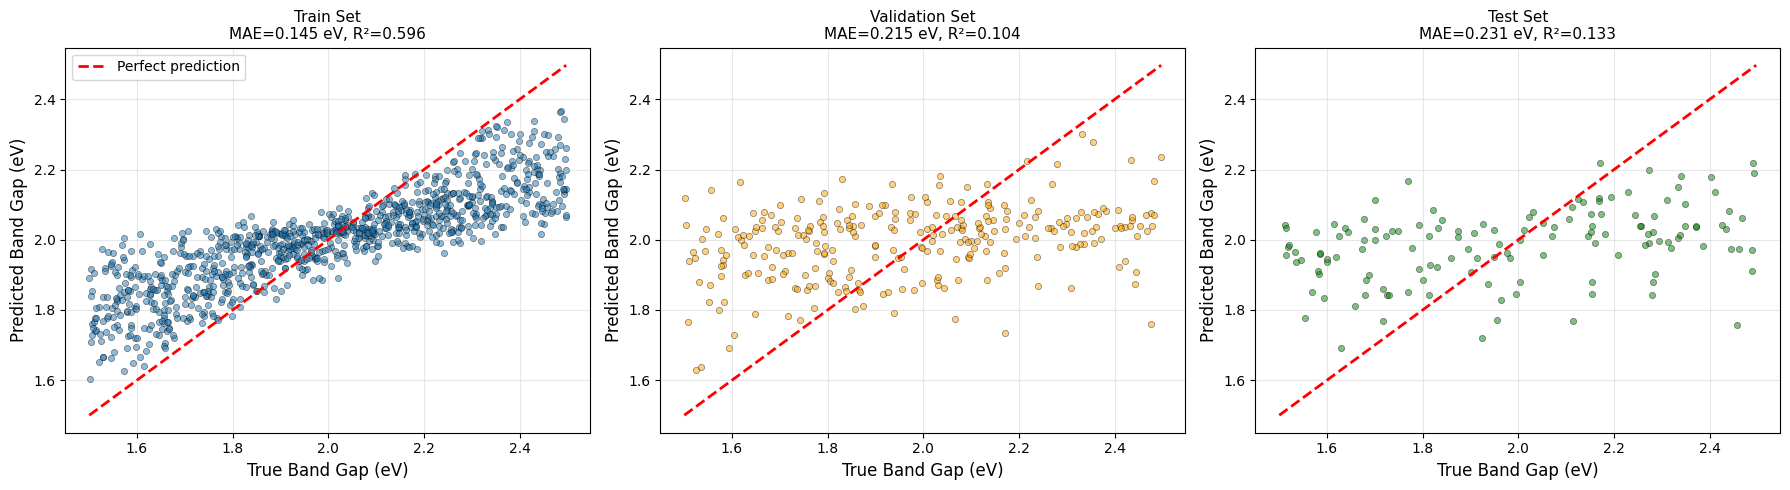

✓ Parity plots saved as 'parity_plots_mp_bandgap.png'


In [12]:
# Create parity plots for all three sets
print("\n" + "="*60)
print("CREATING PARITY PLOTS")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

max_val = max(y_train.max(), y_val.max(), y_test.max())
min_val = min(y_train.min(), y_val.min(), y_test.min())

# Train
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=20, edgecolors='black', linewidths=0.5)
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('True Band Gap (eV)', fontsize=12)
axes[0].set_ylabel('Predicted Band Gap (eV)', fontsize=12)
axes[0].set_title(f'Train Set\nMAE={mae_train:.3f} eV, R²={r2_train:.3f}', fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Validation
axes[1].scatter(y_val, y_val_pred, alpha=0.5, s=20, edgecolors='black', linewidths=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[1].set_xlabel('True Band Gap (eV)', fontsize=12)
axes[1].set_ylabel('Predicted Band Gap (eV)', fontsize=12)
axes[1].set_title(f'Validation Set\nMAE={mae_val:.3f} eV, R²={r2_val:.3f}', fontsize=11)
axes[1].grid(alpha=0.3)

# Test
axes[2].scatter(y_test, y_test_pred, alpha=0.5, s=20, edgecolors='black', linewidths=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[2].set_xlabel('True Band Gap (eV)', fontsize=12)
axes[2].set_ylabel('Predicted Band Gap (eV)', fontsize=12)
axes[2].set_title(f'Test Set\nMAE={mae_test:.3f} eV, R²={r2_test:.3f}', fontsize=11)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('parity_plots_mp_bandgap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Parity plots saved as 'parity_plots_mp_bandgap.png'")

In [13]:
# Create summary dataframe
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

summary_data = {
    'Metric': ['Dataset Size', 'SOAP Features', 'Target Property', 
               'Test MAE (eV)', 'Test RMSE (eV)', 'Test R²', 'Baseline MAE (eV)'],
    'Value': [
        len(df),
        X_clean.shape[1],
        'Band Gap',
        f'{mae_test:.4f}',
        f'{rmse_test:.4f}',
        f'{r2_test:.4f}',
        f'{baseline_mae:.4f}'
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv('mp_ml_pipeline_summary.csv', index=False)
print("\n✓ Summary saved to 'mp_ml_pipeline_summary.csv'")

print("\n" + "="*60)
print("✅ Assignment 2 Complete!")
print("="*60)


FINAL SUMMARY
           Metric    Value
     Dataset Size     1386
    SOAP Features     5000
  Target Property Band Gap
    Test MAE (eV)   0.2308
   Test RMSE (eV)   0.2747
          Test R²   0.1329
Baseline MAE (eV)   0.2342

✓ Summary saved to 'mp_ml_pipeline_summary.csv'

✅ Assignment 2 Complete!
